In [3]:
import numpy as np
from sklearn import model_selection, datasets, metrics, tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
# min_samples_split - best choise: [1,40]
# min_samples_leaf - best choise: [1,20]
# min_weight_fraction_leaf - это доля входных выборок, которые должны находиться на листовом узле, где веса определяются sample_weight, это способ справиться с дисбалансом классов.
# min_samples_split и min_samples_leaf являются наиболее ответственными за производительность конечных деревьев из анализа их относительной важности 
#  Обычно сложность дерева измеряется одной из следующих метрик: общее количество узлов, общее количество листьев, глубина дерева и количество используемых атрибутов [8]. max_depth, min_samples_split и min_samples_leaf являются критериями остановки, тогда как min_weight_fraction_leaf и min_impurity_decrease являются методами сокращения.


In [4]:
X, y = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 3, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=3, n_samples=100)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.3)

In [5]:
class DecisionTreeCLF(object):
    def __init__(self, min_samples_to_split=6, max_depth=5):
        self.min_samples_to_split = min_samples_to_split
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.unique_classes = np.unique(y) # 1 x K
        Rm = np.concatenate([X,y.reshape((-1,1))], axis=1)
        self.tree = {'root':{'j':0,'t':0}}
        self.splitter(Rm, 0, self.tree['root'])
        
    def split_left_right(self, j, t, Rm):
        # j - индекс j-го признака
        # t - порог отсечения 
        # Rm - множество из (X,y), dim=(n, d+1)
        Rl, Rr = list(), list()
        for row in Rm:
            if row[j] <= t:
                Rl.append(row)
            else:
                Rr.append(row)
        return np.array(Rl), np.array(Rr)

    def gini(self, Rm):
        # считает критерий информативности для какой-то вершины
        if len(Rm) == 0:
            return 0
        p = np.array([np.mean(Rm[:,-1] == k) for k in list(set(Rm[:,-1]))]) # 1*K
        return np.sum(p*(1-p)) # scalar
    
    def get_best_nodes(self, Rm):
        gini_Rm = self.gini(Rm) # считаем Джинни для вершины
        best_IG, best_j, best_t, best_Rl, best_Rr = -np.inf, -1, -1, None, None
        for j in range(len(Rm[0,:-1])): # итерация по признакам
            for row in Rm: # по строкам
                Rl, Rr = self.split_left_right(j, row[j], Rm) # разбиваем вершину на два
                IG = gini_Rm - (len(Rl)/len(Rm)*self.gini(Rl) + len(Rr)/len(Rm)*self.gini(Rr)) # считаем информацию   
                if IG > best_IG: # находим максимум
                    best_IG, best_j, best_t, best_Rl, best_Rr = IG, j, row[j], Rl, Rr            
        return best_Rl, best_Rr, best_j, best_t 


    
    def splitter(self, Rm, depth, node):
        Rl, Rr, j, t = self.get_best_nodes(Rm)
        node['j'], node['t'] = j, t
       
        if len(Rl) >= self.min_samples_to_split and depth < self.max_depth:
            node['left'] = {'j':0,'t':0}
            self.splitter(Rl, depth+1, node['left'])
        else:
            node['response'] = self.clf_response(Rm)
            return
        
        if len(Rr) >= self.min_samples_to_split and depth < self.max_depth:
            node['right'] = {'j':0,'t':0}
            self.splitter(Rr, depth+1, node['right'])
        else:
            node['response'] = self.clf_response(Rm)
            return
    
    def get_response(self, node, row):
        if row[node['j']] > node['t']:
            return self.get_response(node['right'], row) if 'response' not in node else node['response']
        else:
            return self.get_response(node['left'], row) if 'response' not in node else node['response']
        
    def predict(self, X):
        X = np.array(X)
        y_predict = []
        for row in X:
            y_predict.append(self.get_response(self.tree['root'], row))
        return y_predict
        
    
    def clf_response(self, Rm):
        # Возвращаем тот класс, который наиболее популярен среди объектов X_m
        return np.argmax([np.sum(Rm[:,-1]==cl) for cl in self.unique_classes], axis=0)    

In [36]:
clf = DecisionTreeCLF(min_samples_to_split=1, max_depth=100)
clf.fit(X_train,y_train)

In [37]:
np.mean(clf.predict(X_test) == y_test)

0.7666666666666667

In [49]:
clf = DecisionTreeClassifier(min_samples_split=2,  min_samples_leaf=1, max_depth=10)
clf.fit(X, y)
np.mean(clf.predict(X_test) == y_test)

1.0

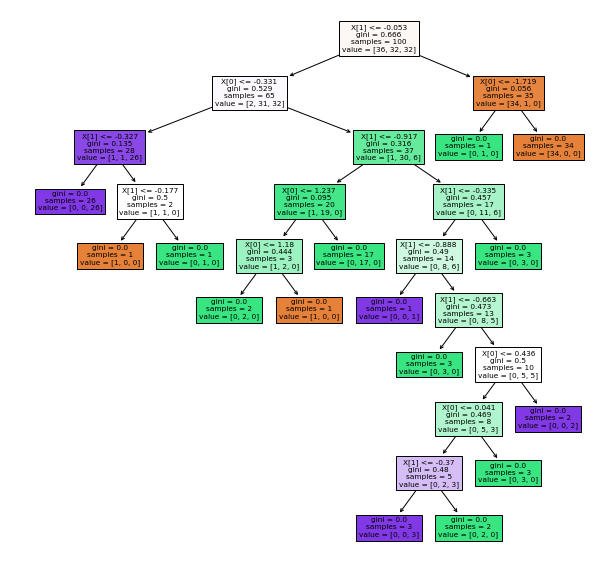

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
tree.plot_tree(clf, filled=True)
plt.show()